# Определение жанра по изображению обложки музыкального альбома

**Данные**

Изображения в формате PNG, упакованные в zip-архивы. Имя архива соответствует музыкальному жанру. Каждый zip-архив содержит папку с изображениями музыкальных обложек соответствующего жанра.

В данных присутсвтуют следующие жанры:
- anime
- black metal
- classical
- country
- disco
- edm
- jazz
- pop
- rap
- reggae

**Задача**
Необходимо разработать модель, которая определит жанр музыкального альбома по изображению его обложки.

**Оцениваемые метрики**: `Accuracy`, `Precision`, `Recall`, `F1`


Сформулируем **план** выполнения задачи

1. Ознакомление с данными.
2. Проведение анализа данных и определение целевой метрики.
3. Подготовка данных для baseline-модели.
4. Создание baseline-модели.
5. Расчет метрик.
6. Подготовка данных для нейронной сети.
7. Обучение нейронной сети (посмотрим на сети ResNet50, ResNet101, ResNet152).
8. Расчет и сравнение метрик.
9. Анализ полученных моделей.


In [1]:
#pip install faiss-cpu

In [1]:
import os
import pandas as pd
from PIL import Image
import numpy as np

import torch
import torchvision.models as models
import torchvision.transforms as transforms

import faiss
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from fastai.vision.all import *

import warnings
warnings.filterwarnings("ignore")


# 1. Ознакомление с данными и проведение их анализа

Напишем функцию для выгрузки изображений альбомов из папок, разделенных по жанрам

In [3]:
def explore_folders(root_dir):
    file_info = []
    for root, dirs, files in os.walk(root_dir):
        for file in files:
            folder_name = os.path.basename(root)  # Получаем имя папки
            file_info.append((folder_name, file))  # Добавляем только имя папки вместо полного пути
    return file_info

In [4]:
root_folder = "/var/tmp/music_project/music_project" #Путь расположения папок с файлами

In [5]:
file_info = explore_folders(root_folder)
len(file_info)

7800

In [6]:
df = pd.DataFrame(file_info, columns=['genre', 'file'])

In [7]:
df.head(10)

genre                                      file
0  anime  470e14cd-3211-46d6-8a27-29b3a1d9043c.png
1  anime  94b80d84-986d-4df1-8574-f1e32996d2ea.png
2  anime  961de7c6-5870-45c5-b495-789b1f9aa250.png
3  anime  41f73a58-ee88-4a8c-ae17-014e104e7210.png
4  anime  b2fffffd-541e-463b-99d3-7cae62983dd8.png
5  anime  79ac90e6-013f-4685-a302-b04f44fa8584.png
6  anime  38b1d698-1bb8-4c49-8131-bfdc69a31340.png
7  anime  a8c1515a-2bba-4dba-8d0a-94e5c44fe5e4.png
8  anime  55da7cfd-cb35-42fc-bb82-fcbfb8b08a51.png
9  anime  87b56756-5d48-4da5-a90a-eaeea3971fcc.png

In [8]:
print(df.sample(5))

            genre                                      file
3220         jazz  55336960-f1c8-4afa-9a34-773a6a388211.png
7113  black metal  e19743f1-f396-3c85-a259-eefe34d93ab2.png
3058         jazz  3332b58a-6a8a-480d-8264-75363dd78535.png
1219       reggae  3e8e30fa-2860-4582-87d5-503be0fe9c73.png
278         anime  3e380d0e-8b2a-4515-a90a-d06562e37321.png


**Вывод по разделу**
1. Импортировали все необходимые для проведения исследования библиотеки
2. Выгрузили все изображения из имеющихся папок
3. Сформировали датафрейм размерностью 7800 на 10, где в столбце `genre` находится наименование жанра, в столбце `file` имя файла формата .png.

# 2. Проведение анализа данных и определение целевой метрики

**2.1 Определение целевой метрики**

Так как задачей является определение жанра музыкального альбома по изображению его обложки, а все альбомы у нас разделены по папкам с названием жанра, это и будет являться нашей целевой метрикой

In [9]:
df['genre'].unique() #Целевая метрика находится в столбце genre

array(['anime', 'reggae', 'edm', 'jazz', 'pop', 'disco', 'country',
       'classical', 'black metal', 'rap'], dtype=object)

**2.2 Проведение анализа данных**

Напишем функцию для выгрузки 5 произвольных обложек с наименованием жанра

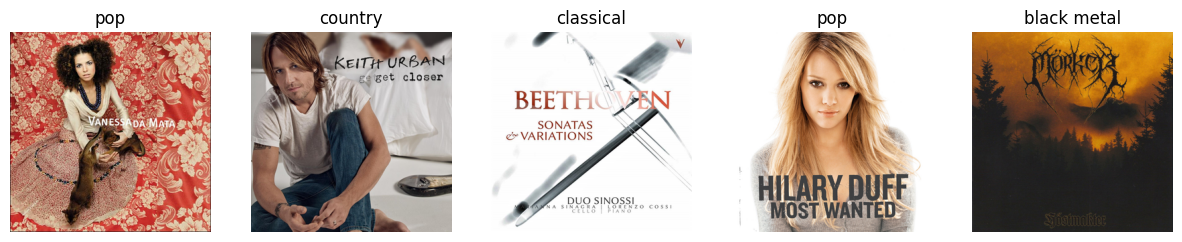

In [10]:
def show_images(df, num_images=5):
    # Выбираем произвольные строки из датафрейма
    sample_df = df.sample(num_images)
    
    # Создаем график для отображения изображений
    plt.figure(figsize=(15, 10))
    
    # Отображаем каждое изображение
    for i, (_, row) in enumerate(sample_df.iterrows()):
        image_path = os.path.join(row['genre'], row['file'])  # Полный путь к изображению
        image = Image.open(os.path.join(root_folder, image_path))  # Открываем изображение
        plt.subplot(1, num_images, i + 1)  # Создаем подграфик
        plt.imshow(image)  # Отображаем изображение
        plt.axis('off')  # Отключаем оси
        plt.title(row['genre'])  # Заголовок - имя файла
        
    plt.show()  # Отображаем график

# Выводим несколько произвольных файлов в виде изображений
show_images(df);

Посмотрим на количественное распределение жанров в имеющихся данных

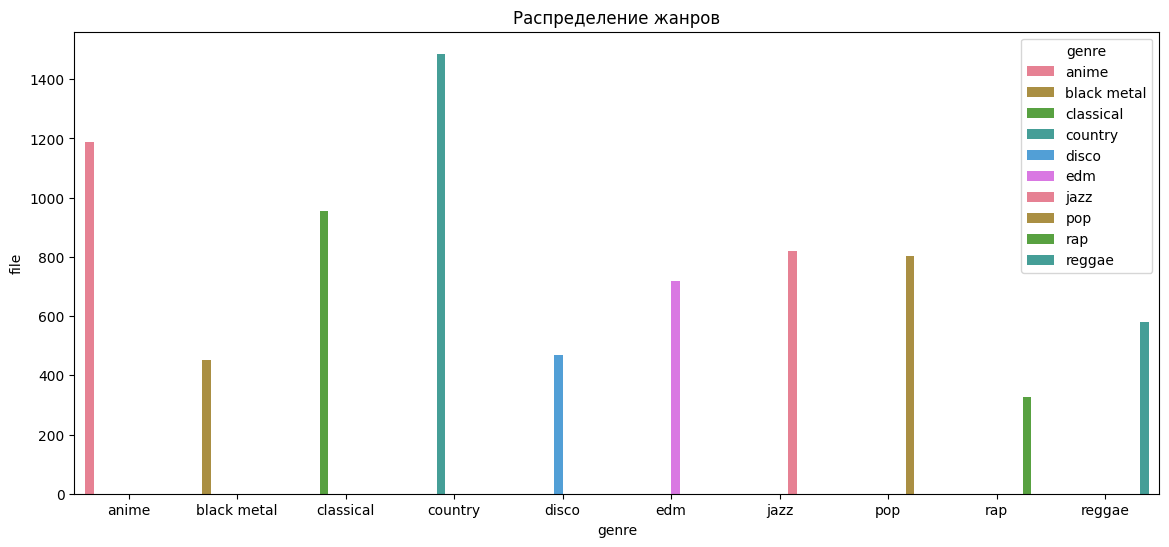

In [11]:
plt.figure(figsize=(14, 6))
df_aggregate = df.groupby('genre').agg({'file' : 'count'}).reset_index()

sns.barplot(data=df_aggregate, 
            x='genre',
            y='file',
            hue='genre',
            palette=sns.color_palette('husl'))
plt.title(f'Распределение жанров');

Из полученного графика распределения видно, что в данных больше всего изображений с жанрами `country` и `anime`, и меньше всего `rap` и `black metal`.

Далее посмотрим на наличие дубликатов в названиях файлов

In [12]:
print("Повторяющиеся названия изображений:")
df[df.duplicated(subset=['file'], keep=False)]

Повторяющиеся названия изображений:


genre                                      file
1768  reggae  5c4f2c7c-8412-39fa-9468-23c52e285cd7.png
3719     pop  9123d325-bf8e-4423-be98-98478dccee20.png
3848     pop  6ea3d2de-f234-4bdd-8ba8-4e9523f5ae1a.png
4101     pop  7e5955d3-c4f3-493c-a3d4-8b855bfc1833.png
4432   disco  6ea3d2de-f234-4bdd-8ba8-4e9523f5ae1a.png
4579   disco  5c4f2c7c-8412-39fa-9468-23c52e285cd7.png
7651     rap  9123d325-bf8e-4423-be98-98478dccee20.png
7796     rap  7e5955d3-c4f3-493c-a3d4-8b855bfc1833.png

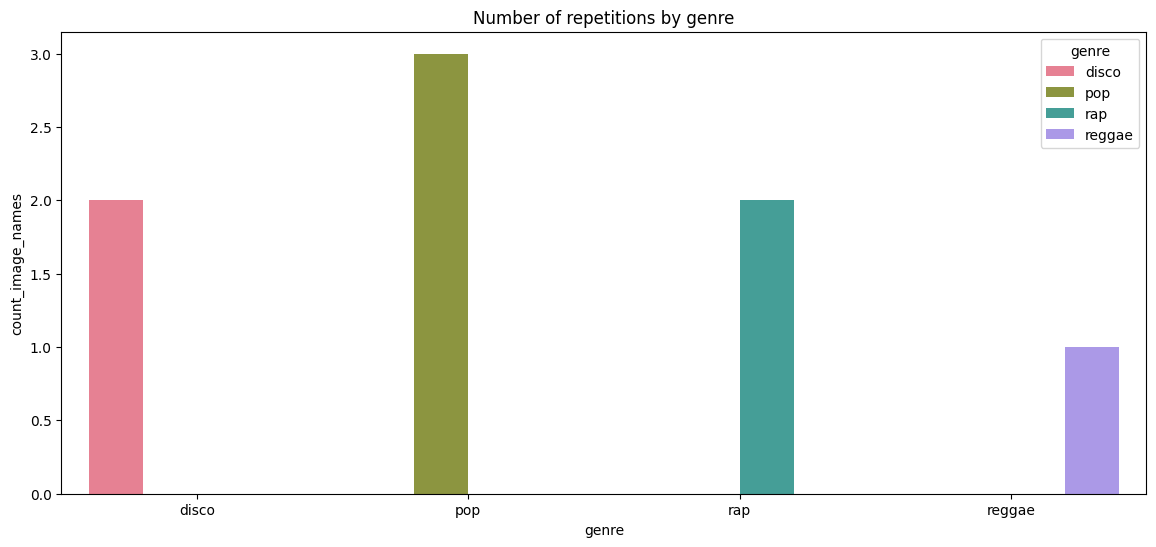

In [13]:
plt.figure(figsize=(14, 6))
df_agg = df[df.duplicated(subset=['file'],
                          keep=False)].groupby('genre').agg({'file': 'count'}).reset_index()
df_agg.rename(columns={'file': 'count_image_names'}, inplace=True)
sns.barplot(data=df_agg,
            x='genre',
            y='count_image_names',
            hue='genre',
            palette=sns.color_palette("husl", len(df_agg)))

plt.title(f"Number of repetitions by genre");

**Вывод по разделу**

1. Определена целевая метрика, которая находится в столбце `genre`
2. Выведены произвольные изображения с наименованием их жанра
3. Построено количественное распределение жанров в датафрейме. Из данного распределения видно, что в данных больше всего изображений с жанром `country` и меньше всего с жанром `rap`.
4. Обнаружено несколько совпадений названий изображений, их анализ показал, что альбомы с этими изображаениями относятся к различным музыкальным жанрам;
5. Жанр, в котором больше всего пересечений альбомов с другими жанрами - `pop`

# 3. Подготовка данных для baseline-модели

In [14]:
# Путь к папке с обложками альбомов, разделенными по папкам, где название папки - это жанр
album_covers_folder = "/var/tmp/music_project/music_project"


In [15]:
# Загрузка предварительно обученной модели глубокого обучения
model = models.resnet50(pretrained=True)
model.eval()
# Удаление последнего слоя классификатора, чтобы получить векторные представления
model = torch.nn.Sequential(*(list(model.children())[:-1]))

In [16]:
# Преобразование изображений для подачи на вход модели
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [17]:
# Функция для получения векторных представлений обложек альбомов и соответствующих меток жанров
def get_album_cover_vectors_and_labels(folder_path, model, transform):
    vectors = []
    labels = []
    for genre_folder in os.listdir(folder_path):
        genre_path = os.path.join(folder_path, genre_folder)
        if os.path.isdir(genre_path):
            for file_name in os.listdir(genre_path):
                image_path = os.path.join(genre_path, file_name)
                image = Image.open(image_path).convert('RGB')
                image_tensor = transform(image).unsqueeze(0)
                with torch.no_grad():
                    features = model(image_tensor).squeeze().numpy()
                vectors.append(features)
                labels.append(genre_folder)
    return np.array(vectors), labels

In [18]:
# Получение векторных представлений обложек альбомов и меток жанров
album_cover_vectors, genre_labels = get_album_cover_vectors_and_labels(album_covers_folder, model, transform)

In [19]:
album_cover_vectors.shape

(7800, 2048)

In [20]:
len(genre_labels)

7800

**Выводы по разделу**
1. Загружена предварительно обученная модель обучения ResNet50 для дальнейшего преобразования наших изображений в эмбединги и использования их в FAISS модели
2. Проведено преобразование изображений для подачи на вход модели с помощью функции `transforms` из библиотеки `torchvision`
3. Создана функция для получения векторных представлений обложек альбомов и соответствующих меток жанров
4. Получен массив векторов размерностью 7800 на 2048, который далее будет "прогоняться" через baseline модель FAISS

# 4. Создание baseline-модели

В качестве baseline модели будем рассматривать модель на основе FAISS - Facebook AI Research Similarity Search – разработка команды Facebook AI Research для быстрого поиска ближайших соседей и кластеризации в векторном пространстве. Высокая скорость поиска позволяет работать с очень большими данными – до нескольких миллиардов векторов.

In [21]:
# Создание индекса с использованием FAISS
index = faiss.IndexFlatL2(album_cover_vectors.shape[1])
index.add(album_cover_vectors)


In [22]:
print(index)

<faiss.swigfaiss_avx512.IndexFlatL2; proxy of <Swig Object of type 'faiss::IndexFlatL2 *' at 0x7fcc159e7870> >


Напишем функцию для предсказания жанра

In [23]:
def predict_genre(album_cover_path, index, model, transform):
    # Получение вектора для данной обложки альбома
    image = Image.open(album_cover_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0)
    with torch.no_grad():
        features = model(image_tensor).squeeze().numpy()

    # Поиск ближайших соседей с помощью FAISS
    D, I = index.search(np.array([features]), k=5)  # Ищем 5 ближайших соседей

    return I

Напишем функцию для определения основных оцениваемых метрик `accuracy`, `precision`, `recall`, `f1` 

In [24]:
def calculate_metrics(actual_labels, predicted_labels):
    # Расчет Accuracy
    accuracy = accuracy_score(actual_labels, predicted_labels)
    
    # Расчет Precision
    precision = precision_score(actual_labels, predicted_labels, average=None)
    precision_dict = {label: score for label, score in zip(range(len(precision)), precision)}
    
    # Расчет Recall
    recall = recall_score(actual_labels, predicted_labels, average=None)
    recall_dict = {label: score for label, score in zip(range(len(recall)), recall)}
    
    # Расчет F1 Score
    f1 = f1_score(actual_labels, predicted_labels, average=None)
    f1_dict = {label: score for label, score in zip(range(len(f1)), f1)}
    
    return accuracy, precision_dict, recall_dict, f1_dict

**Вывод по разделу**
1. С помощью FAISS создан индекс для дальнейшего поиска ближайших соседей
2. Создана функция, которая получает вектор для данной обложки альбома и затем методом поиска ближайших соседей дает предсказание
3. Создана функция, которая оценивает "производительность" модели по метрикам `accuracy`, `precision`, `recall`, `f1` 

# 5. Расчет метрик

Напишем функцию для получения предсказаний и расчета основных метрик

In [25]:
def evaluate_model(index, model, transform, genre_labels):
    actual_labels = []
    predicted_labels = []

    for genre_folder in os.listdir(album_covers_folder):
        genre_path = os.path.join(album_covers_folder, genre_folder)
        if os.path.isdir(genre_path):
            for file_name in os.listdir(genre_path):
                album_cover_path = os.path.join(genre_path, file_name)
                actual_genre = genre_folder

                # Получение ближайших соседей с помощью модели
                predicted_neighbors = predict_genre(album_cover_path, index, model, transform)
                # Пример: Предположим, что мы определяем жанр по самому частому жанру среди соседей
                predicted_genre = Counter([genre_labels[index] for index in predicted_neighbors.flatten()]).most_common(1)[0][0]

                actual_labels.append(actual_genre)
                predicted_labels.append(predicted_genre)

    accuracy, precision, recall, f1 = calculate_metrics(actual_labels, predicted_labels)
    return accuracy, precision, recall, f1

In [26]:
# Оценка производительности модели
accuracy, precision, recall, f1 = evaluate_model(index, model, transform, genre_labels)

In [27]:
print("Accuracy:", accuracy)

Accuracy: 0.7521794871794871


In [28]:
genre_1 = ['anime', 'reggae', 'edm', 'jazz', 'pop', 'disco', 'country',
       'classical', 'black metal', 'rap']

In [29]:
data = {
    'Genre': list(genre_1),
    'Precision': list(precision.values()),
    'Recall': list(recall.values()),
    'F1 Score': list(f1.values())
}

df_new = pd.DataFrame(data)

display(df_new)

Genre  Precision    Recall  F1 Score
0        anime   0.809561  0.868797  0.838134
1       reggae   0.911628  0.871111  0.890909
2          edm   0.756906  0.860733  0.805488
3         jazz   0.696217  0.829744  0.757138
4          pop   0.716129  0.474359  0.570694
5        disco   0.822764  0.703755  0.758621
6      country   0.691808  0.647990  0.669182
7    classical   0.744986  0.647572  0.692871
8  black metal   0.773234  0.634146  0.696817
9          rap   0.692708  0.686747  0.689715

**Вывод по разделу**
1. Получили, что для модели FAISS метрика `Accuracy` составляет `0.752`
2. Метрики `Precision`, `Recall`, `F1 Score` для каждого жанра приведены в таблице выше.

# 6. Подготовка данных для нейронной сети

In [2]:
# Путь к папке с данными
path = '/var/tmp/music_project/music_project'

In [3]:
# Напишем функцию для выделения таргета/метки
def label_function(file_path):
    # Предполагая что метка является предпоследним каталогом в пути к файлу
    return file_path.parent.name

Создаём объект класса DataBlock, являющийся контейнером, содержащим информацию о наших данных и о предобработке, которую нужно осуществить

In [4]:
genre = DataBlock(blocks=(ImageBlock, CategoryBlock), 
                 get_items=get_image_files, 
                 splitter=RandomSplitter(),
                 get_y=label_function,
                 item_tfms=Resize(460),
                 batch_tfms=aug_transforms(size=224))

In [5]:
#Загружаем наши данные
loader = genre.dataloaders(path) 

Теперь посмострим верно ли прошла разметка по жанрам наших изображений

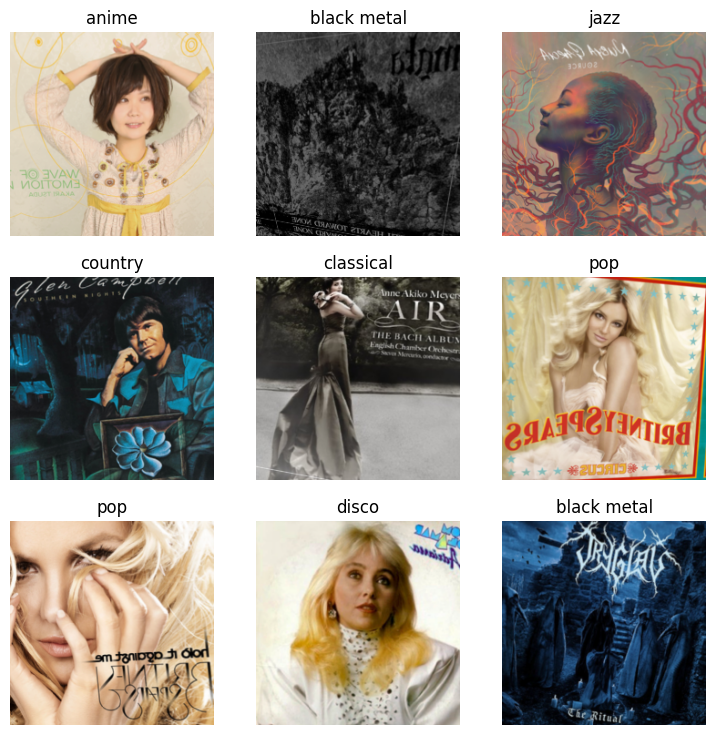

In [6]:
loader.show_batch(max_n=9)

**Вывод по разделу**
1. Создали объект класса DataBlock, являющийся контейнером, содержащим информацию о наших данных.
2. Также в объекте DataBlock провели необходимую предобработку изображений 
3. Проверили правильность проведения разметки наших изображений. Разметка проведена правильно

# 7. Обучение нейронной сети 

Для обучения моделей будем пользоваться библиотекой `fastai`. Рассмотрим предобученные модели `ResNet50`, `ResNet101`, `ResNet152`

**Модель ResNet50**

In [7]:
arch_50 = models.resnet50; #определяем архитектуру сети как ResNet50

In [8]:
#Создаем модель
learner_50 = vision_learner(loader,
                         models.resnet50,
                         metrics=accuracy,
                         loss_func=CrossEntropyLossFlat())

SuggestedLRs(valley=0.0014454397605732083)

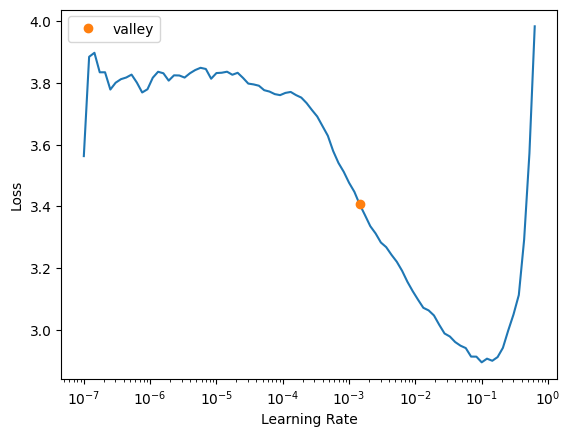

In [9]:
learner_50.lr_find() #Найдем оптимальное для Resnet50 значение learning rate

In [10]:
#Обучим модель и посмотрим на метрики на каждой эпохе. Количество эпох - 10
learner_50.fine_tune(10, 0.001) 

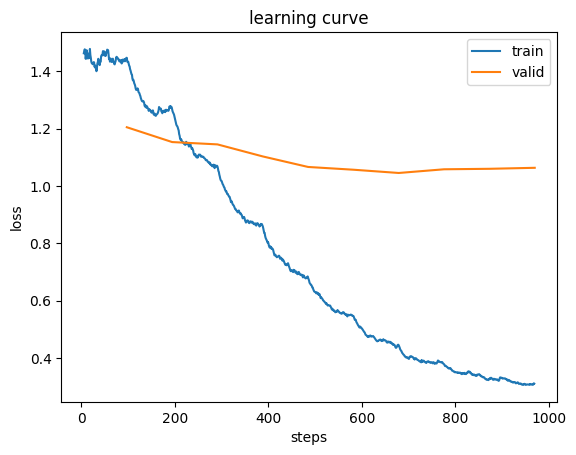

In [11]:
# Построим график потерь
learner_50.recorder.plot_loss();

**Модель ResNet101**

In [12]:
arch_101 = models.resnet101; #определяем архитектуру сети как ResNet101

In [13]:
#Создаем модель
learner_101 = vision_learner(loader,
                         arch_101,
                         metrics=accuracy,
                         loss_func=CrossEntropyLossFlat())

SuggestedLRs(valley=0.0010000000474974513)

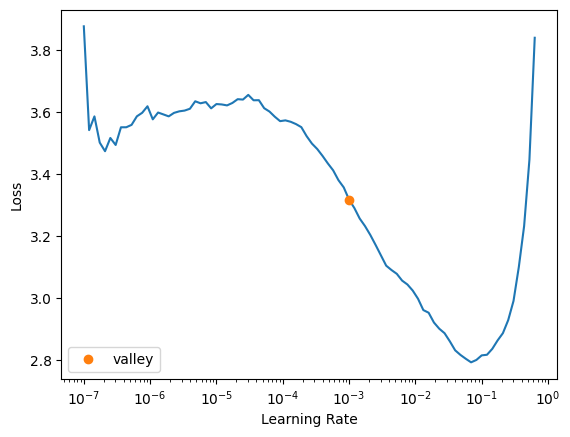

In [14]:
learner_101.lr_find() #Найдем оптимальное для Resnet50 значение learning rate

In [15]:
#Обучим модель и посмотрим на метрики на каждой эпохе. Количество эпох - 15
learner_101.fine_tune(10, 0.001) 

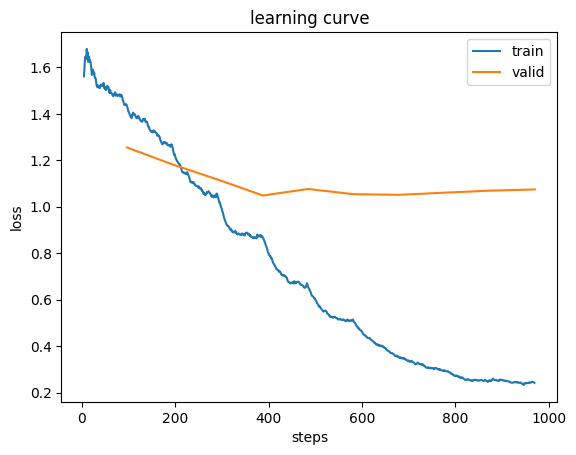

In [16]:
# Построим график потерь
learner_101.recorder.plot_loss();

**Модель ResNet152**

In [17]:
arch_152 = models.resnet152; #определяем архитектуру сети как ResNet152

In [18]:
#Создаем модель
learner_152 = vision_learner(loader,
                         arch_152,
                         metrics=accuracy,
                         loss_func=CrossEntropyLossFlat())

SuggestedLRs(valley=0.0005754399462603033)

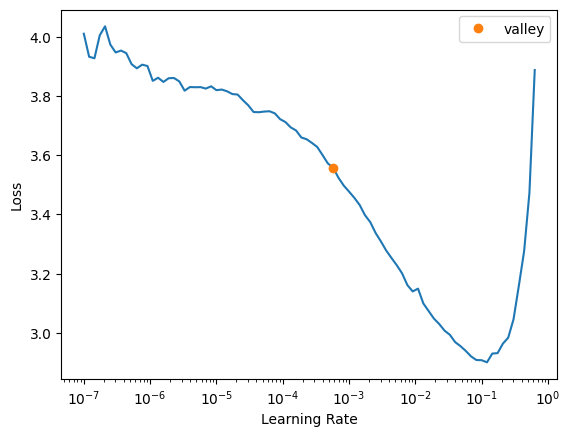

In [19]:
learner_152.lr_find()

In [20]:
learner_152.fine_tune(10, 0.001) 

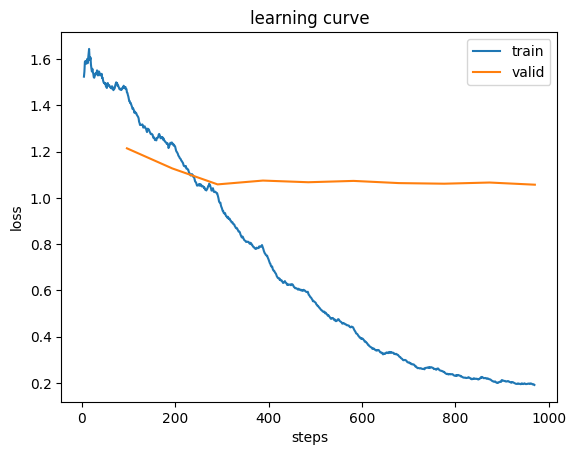

In [21]:
# Построим график потерь
learner_152.recorder.plot_loss();

**Вывод по разделу**

Обучили три разные модели ResNet50, ResNet101 и ResNet152. Получили следующие результаты:
- Модель ResNet50 на 10 эпохах дает метрику Accuracy 0.68, время обучения одной эпохи примерно 1 минута;
- Модель ResNet101 на 15 эпохах дает метрику Accuracy 0.70, время обучения одной эпохи примерно 2 минуты;
- Модель ResNet152 на 10 эпохах дает метрику Accuracy 0.68, время обучения одной эпохи примерно 2 минуты;

# 8. Анализ модели

Получили, что наилучшее значение Accuracy у модели ResNet101. Посмотрим на результаты

1. Построим матрицу ошибок

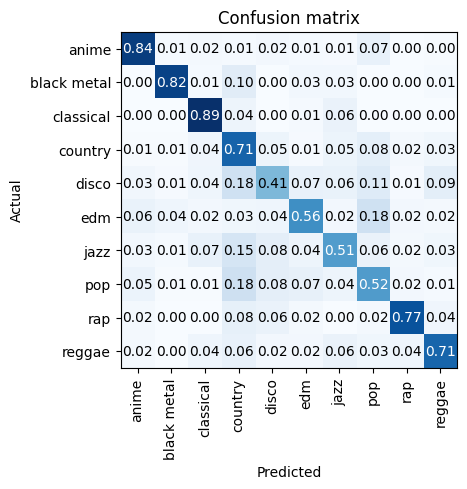

In [22]:
results = ClassificationInterpretation.from_learner(learner_101)
results.plot_confusion_matrix(normalize = True, 
                              title = 'Confusion matrix',
                              cmap='Blues',
                              norm_dec=2,
                              plot_txt=True)

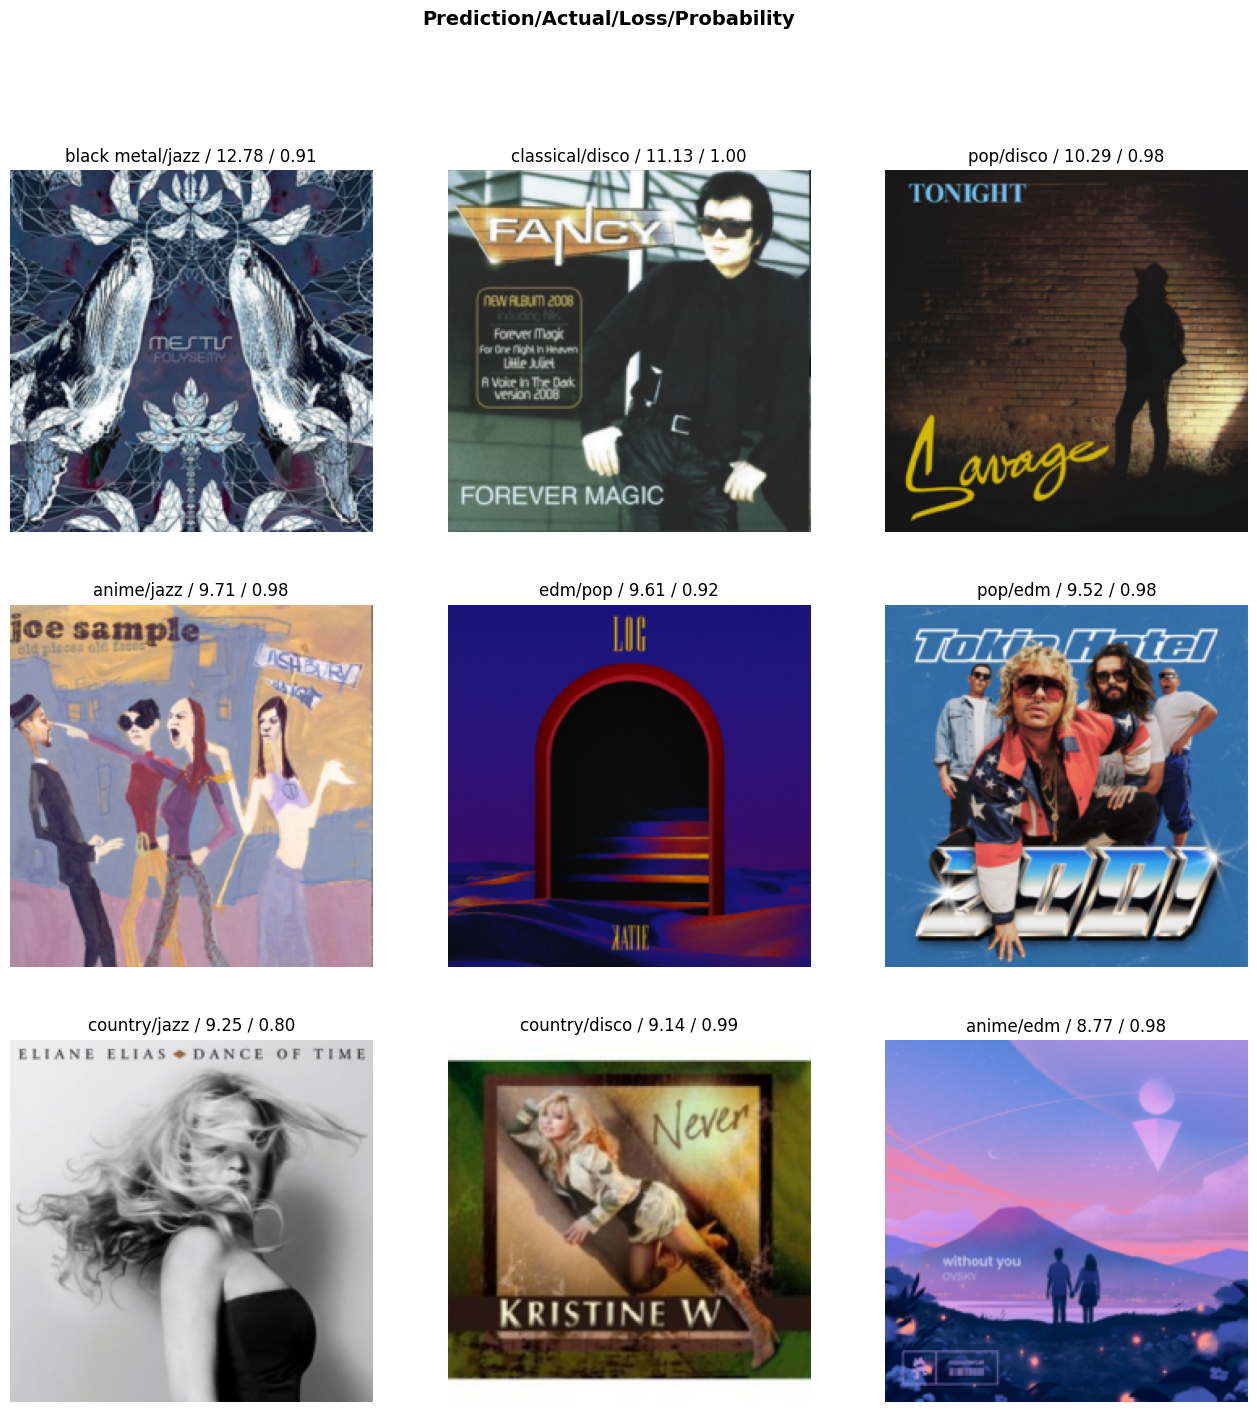

In [23]:
results.plot_top_losses(9, figsize= (16,16))

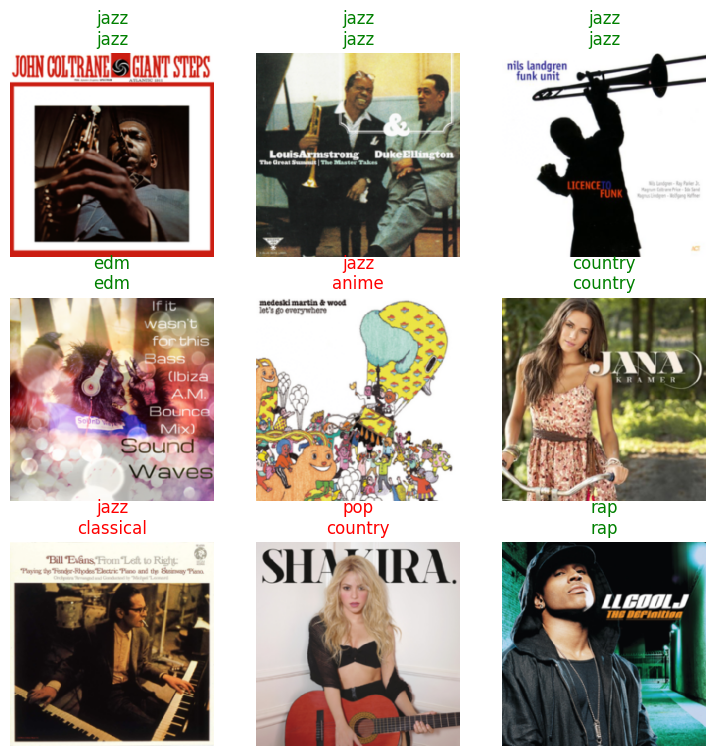

In [24]:
learner_101.show_results()

**Выводы по разделу**

1. Построена матрица ошибок, которая показывает:
   - Наиболее точно определяются жанры: `anime`, `black_metal`, `classical`, `country`, `rap`;
   - Хуже всех определяются жанры - `disco`, `jazz`, `pop`;
   - Меньше всего некорректных жанров предсказывается для жанра `anime`;

2. Так же обнаружено, что при некорректном предсказании жанры чаще всего предсказываются жанром `country`. Это можно объяснить тем, что в данных больше всего файлов именно с этим жанром.

# 9. Итоговые выводы

Нашей задачей было построить модель, способную предсказывать жанр по обложке альбома. При проведении данного исследования:

1. Выгружены данные в тетрадку и сформирован датафрейм размерностью 7800 изображений на 10 жанров, состоящий из наименования файла и жанра. Столбец с жанром определен как целевая метрика, которую и нужно предсказать. 
2. Проведен исследовательский анализ данных. Обнаружено, что в данных больше всего изображений с жанром `country` и меньше всего с жанром `rap`. Также обнаружено несколько совпадений названий изображений, их анализ показал, что альбомы с этими изображаениями относятся к различным музыкальным жанрам. Определено, что жанр, в котором больше всего пересечений альбомов с другими жанрами - `pop`.
3. Далее была загружена предварительно обученная модель ResNet50 для дальнейшего преобразования наших изображений в эмбединги и использования их в FAISS модели. Проведено преобразование изображений для подачи на вход модели с помощью функции transforms из библиотеки torchvision. Создана функция для получения векторных представлений обложек альбомов и соответствующих меток жанров. Таким образом, получен массив векторов размерностью 7800 на 2048, который далее "прогнали" через baseline модель FAISS.


4. По результатам проверки baseline модели получили метрику `Accuracy = 0.75`.
Метрики `precision`, `recall`, `f1` полученные для каждого жанра приведены в таблице

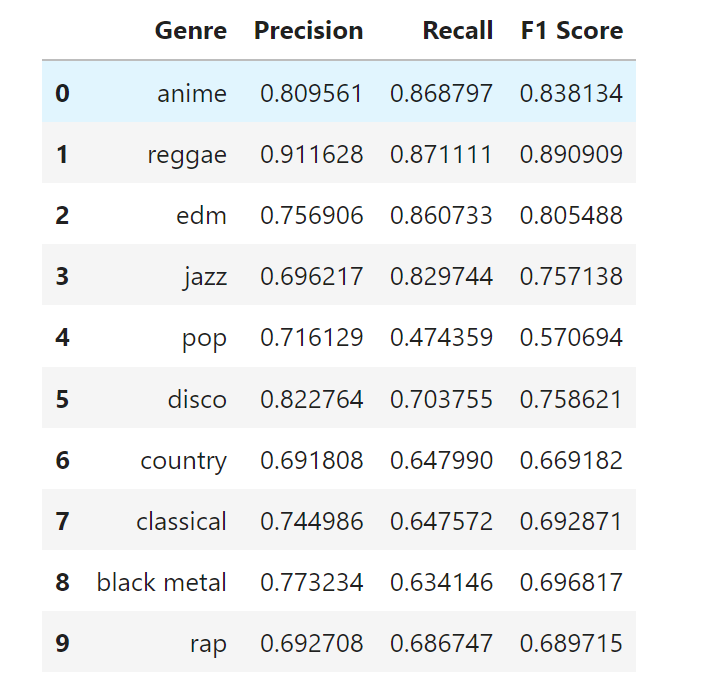

5. Для работы с нейронными сетями создали объект класса DataBlock, являющийся контейнером, содержащим информацию о наших данных и о предобработке, которую нужно осуществить
6. Для обучения моделей воспользовались библиотекой `fastai`. Рассмотрели предобученные модели `ResNet50`, `ResNet101`, `ResNet152` и получили следующие результаты по метрике `accuracy`

- `ResNet50` на 10 эпохах Accuracy = 0.68
- `ResNet101` на 10 эпохах Accuracy = 0.69
- `ResNet152` на 10 эпохах Accuracy = 0.695

Таким образом получили, что наилучшими показателями с учетом скорости обучения обладает модель ResNet101.

На данной модели построена матрица ошибок, которая показывает, что:
   - Наиболее точно определяются жанры: `anime`, `black_metal`, `classical`, `country`, `rap`;
   - Хуже всех определяются жанры - `disco`, `jazz`, `pop`;
   - Меньше всего некорректных жанров предсказывается для жанра `anime`;

Так же обнаружено, что при некорректном предсказании жанры чаще всего предсказываются жанром `country`. Это можно объяснить тем, что в данных больше всего файлов именно с этим жанром.